# Assignment Summary

**Denoising autoencoders**: We will evaluate denoising autoencoders applied to the MNIST dataset.

* Obtain (or write! but this isn't required) a pytorch/tensorflow/etc. code for a denoising autoencoder. Train this autoencoder on the MNIST dataset. Use only the MNIST training set. You should use at least three layers in the encoder and in the decoder.
* We now need to determine how well this autoencoder works. For each image in the MNIST test dataset, compute the residual error of the autoencoder. This is the difference between the true image and the reconstruction of that image by the autoencoder. It is an image itself. Prepare a figure showing the mean residual error, and the first five principal components. Each is an image. You should preserve signs (i.e. the mean residual error may have negative as well as positive entries). The way to show these images most informatively is to use a mid gray value for zero, then darker values for more negative image values and lighter values for more positive values. The scale you choose matters. You should show
    * mean and five principal components on the same gray scale for all six images, chosen so the largest absolute value over all six images is full dark or full light respectively and
    * mean and five principal components on a scale where the gray scale is chosen for each image separately.

**Variational autoencoders**: We will evaluate variational autoencoders applied to the MNIST dataset.
  * Obtain (or write! but this isn't required) a pytorch/tensorflow/etc. code for a variational autoencoder. Train this autoencoder on the MNIST dataset. Use only the MNIST training set.
  * We now need to determine how well the codes produced by this autoencoder can be interpolated.
    * For 10 pairs of MNIST test images of the same digit, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.
    * For 10 pairs of MNIST test images of different digits, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.

**Hints and References**: For the denoising autoencoder, there is an abundance of code online should you choose to obtain one. It may be a good practice to also implement this part from scratch and test what you learned in the CNN assignment. All you have to do is define a network with two groups of layers:
  * *Encoder Layers*: This part must take an image and produce a low-dimensional "code" of the image. Therefore, the architecture of the netwok must be narrowing down. Let's call this function $f^{\text{encoder}}$.
  * *Decoder Layers*: This part must take a low-dimensional "code" of the image and produce the original image. Therefore, the architecture of the netwok must be expanding. Let's call this function $f^{\text{decoder}}$.
  
All you have to do is to try and write some code to minimize the following loss:

$$\mathcal{L} = \frac{1}{N} \sum_{i=1}^N \|x_i - f^{\text{decoder}}(f^{\text{encoder}}(x_i))\|_2^2$$

You may pick any architecture that works as long as it has three layes. The MNIST data has 784 pixels. Therefore, a fully connected network which takes 784 reshaped dimensions to $h_1$ dimensions, then to $h_2$ dimensions, and finally to $h_3$ dimensions is an excellent starting point for an encoder. A vast range of choices can work for these three numbers, but just to give you an idea about their plausible range of values, $h_1$ could be in the order of hundreds, $h_2$ could be in order of tens (or at most a few hundreds), and $h_3$ is supposed to be a low-dimension (preferrably under 10 or at most 20).

You can reverse the encoder architecture, to obtain a decoder, and then stack an SGD optimizer on top with default hyper-parameters to train your denoising autoencoder. You must be familiar with the rest of the concepts from earlier assignments such as multi-dimensional scalings and PCA. You also would need to write some basic code to visualize using matplotlib, PIL, etc.

For VAEs, you may also be able to implement everything from scratch once you review the material. However, there are a lot of resources and examples for implementing VAEs, and here we share a few of them:

  1. Pytorch Tutorials has an example for training VAEs at https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py
  2. Another pytorch example for VAEs can be found at https://github.com/pytorch/examples/blob/master/vae/main.py
  3. Pyro is a library for bayesian optimization and is based on pytorch, which has a detailed tutorial on how to train VAEs with some high-level story of the math involved https://pyro.ai/examples/vae.html
  4. BoTorch is another bayesian optimization library based based on pytorch and has some tutorials for implementing VAEs https://botorch.org/tutorials/vae_mnist
  5. If you're a tensorflow fan, you may find some tutorial at https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE or  https://www.tensorflow.org/tutorials/generative/cvae
  6. Keras fans can also see https://keras.io/examples/generative/vae/
  7. etc.
  
The MNIST data is provided at `./data_mnist` so that you could use the `torchvision` API for loading the data just like the previous assignment.

**Important Note**: This assignment will not be automatically graded and is optional. Therefore, do not expect meaninful grades to be published upon or after submission. However, please make sure to submit your work if you expect it to be reviewed by the instructors for any reason. We will consider the latest submission of your work. 

Any work that is not submitted will not be viewed by us.

### Installing Numpy, PyTorch and Dependencies

In [1]:
%matplotlib inline
import numpy as np
import torch
import botorch
import pyro
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

In [2]:
import os
import torch
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

### Principal Components

A function that uses scikit-learn's TruncatedSVD decomposition instead of the precise np.linalg.svd decomposition.

Returns the principal components of a data matrix and take the following arguments as input

1. `data_raw`: a numpy array with the shape $(N, \cdots)$, where $N$ is the number of samples, and there may be many excess dimensions denoted by $\cdots$. This will be reshaped to obtain a shape of $(N, d)$, where $d$ is the vectorized data's dimension. For example, `data_raw` could have an input shape of `(128, 28, 28)`. In this case it will be reshaped to have a shape of `(128, 784)`.
2. `num_components`: This is the number of PCA components that we want to retain. 

`principal_components` returns the variables `mu_vectors` and `V_x`. `mu_vecors` is a numpy array with the shape `(1, d)`. `V_x` is a numpy array with the shape `(d, num_components)`. The columns are the unitay principal components sorted descendingly with respect to the eigenvalues.

In [3]:
def principal_components(data_raw, num_components=5):
    
    # your code here
    N = data_raw.shape[0]
    data_vectors = data_raw.reshape(N,-1)
    
    #Center Data
    mu_vectors = np.mean(data_vectors, axis = 0).reshape(1,-1)
    data_vectors = data_vectors - mu_vectors
    
    svd = TruncatedSVD(n_components=num_components, algorithm='randomized', n_iter=5, random_state=12345)
    svd.fit(data_vectors)
    V_x = np.transpose(svd.components_)
    
    assert V_x.ndim==2
    # Don't mind/change the following lines. 
    # This is for mitigating the ambiguity up to -/+1 factor in PCs.
    # (i.e., if x is a unitary PC, then -x is also a unitary PC).
    # We multiply each column by the sign of the largest element (in absolute value) of that column
    sign_unambiguity = np.sign(V_x[np.abs(V_x).argmax(axis=0), np.arange(V_x.shape[1])]).reshape(1,-1)
    V_x *= sign_unambiguity
    return mu_vectors, V_x

## 1. denoising autoencoder model
Define the autoencoder model - DAE

In [4]:
"""
Here, we define the denoising autoencoder model.
"""

class DAE(nn.Module):
    def __init__(self):
        super(DAE,self).__init__()
        self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,10),
                  nn.ReLU(True)
        
                  )
    
        self.decoder=nn.Sequential(
                  nn.Linear(10,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
    def forward(self,x):
        y=self.encoder(x.view(-1, 784))
        z=self.decoder(y)
        return z

### **Datasets and Dataloaders**

In [37]:
BATCH_SIZE = 128
LOG_INTERVAL = 10

transform_train=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))])

transform_test=transforms.Compose([
    transforms.ToTensor()])

# Download or load downloaded MNIST dataset
# shuffle data at every epoch
trainset = torchvision.datasets.MNIST(root='./data_mnist', train=True, transform=transform_test)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Same for test data
testset = torchvision.datasets.MNIST(root='./data_mnist', train=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True)

### Defining The Loss Function and The Optimizer

In [38]:
# 'You can define the loss function and the optimizer of interest here.'
model=DAE()

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)
        
model.apply(init_weights)

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr=0.003)
#optimizer = optim.Adadelta(net.parameters())

### Training the Model

In [55]:
def train(epoch):
    model.train()
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #-----------------Forward Pass----------------------
        # Add gaussian noise and push whole batch of data through to get output
        outputs = model(torch.add(data, torch.randn(data.size()) * 0.1))
            
        # calculate scalar loss
        loss = criterion(outputs, data)
            
        #-----------------Backward Pass---------------------
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader),
                        loss.data.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*128) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(model.state_dict(), './mnist_dae_model.pth')
            torch.save(optimizer.state_dict(), './mnist_dae_optimizer.pth')


In [56]:
def evaluate():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0), -1)
            
            # Add gaussian noise and push whole batch of data through to get output
            output = model(torch.add(data, torch.randn(data.size()) * 0.1))
            
            test_loss += criterion(output, data)
            
    test_losses.append(test_loss.data.item())
    print('\nTest set: Avg. loss: {:.6f}%\n'.format(test_loss.data.item()))

In [57]:
#losslist=list()
#train(model, train_loader, optimizer, num_epochs = 12)
num_epochs = 60
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]
for epoch in range(1, num_epochs):
    train(epoch)
    evaluate()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.015611
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.015962
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.015392
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.014809
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.016216
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.015503
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.015480
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.016357
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.016393
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.016309
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.014936
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.015553
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.015448
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.015009
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.015345
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.015234
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.017053
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.015772
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.015139
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.016005
Train Epoch: 1 [

### Evaluating the Model's Performance

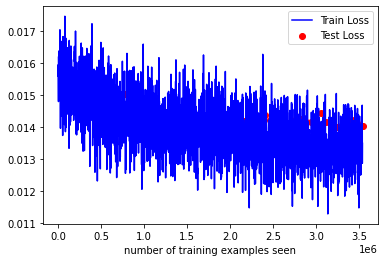

<Figure size 432x288 with 0 Axes>

In [93]:
test_counter = [i*len(train_loader.dataset) for i in range(1,num_epochs)]
#fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
fig = plt.figure()

### Load the model
Only needed if the data has been reset or we need to continue training

In [44]:
PATH = './mnist_dae_model.pth'
model=DAE()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Evaluating the Trained Model

In [58]:
def test(model, test_loader):
    # toggle model to train mode
    model.eval()
    
    running_loss = 0.0
    items = 0.0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.view(data.size(0), -1)
            outputs = model(torch.add(data, torch.randn(data.size()) * 0.1))
            
            running_loss += torch.sum(torch.sub(data, outputs), dim=0) # size = [1, ncol]
            error = torch.sub(data, outputs)
            items += outputs.size()[0]
    
    mre = torch.div(running_loss, items)
    return mre, error
            
            

### Visualizing the mean error and 5 principal Components using a single color scale

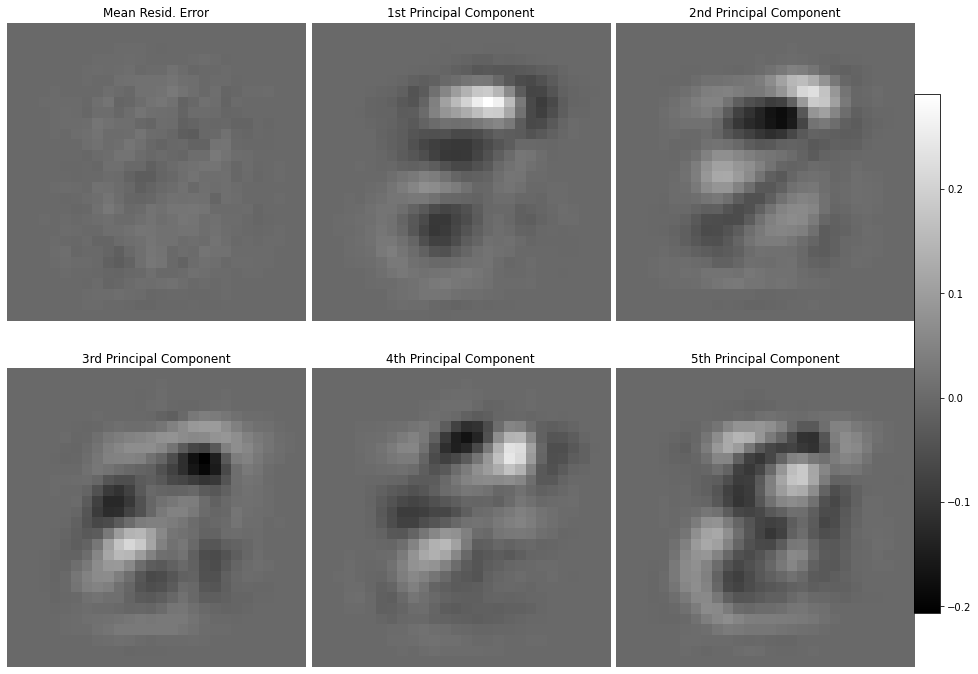

In [59]:
from mpl_toolkits.axes_grid1 import ImageGrid
error, raw_data = test(model, test_loader)

mean, vx = principal_components(raw_data.numpy(), num_components=5)

vx = torch.from_numpy(vx)
mean = torch.from_numpy(mean)

# Display a 2D manifold of the digits
digit_size = 28

#Get min/max for colorbar
min = torch.min(torch.min(vx), torch.min(mean))
max = torch.max(torch.max(vx), torch.max(mean))

# decode for each square in the grid
im1 = mean.reshape(digit_size, digit_size)
im2 = vx[0:784,0].reshape(28,28)
im3 = vx[0:784,1].reshape(28,28)
im4 = vx[0:784,2].reshape(28,28)
im5 = vx[0:784,3].reshape(28,28)
im6 = vx[0:784,4].reshape(28,28)


g = []
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18., 12.))
for ax,im in zip(axes.flat, [im1, im2, im3, im4, im5, im6]):
    g.append(ax)
    ax.set_axis_off()
    img = ax.imshow(im, cmap='binary_r', vmin=min, vmax=max)

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.0001)

cb_ax = fig.add_axes([0.8, 0.19, 0.02, 0.6])
cbar = fig.colorbar(img, cax=cb_ax)
    
g[0].set_title('Mean Resid. Error')
g[1].set_title('1st Principal Component')
g[2].set_title('2nd Principal Component')
g[3].set_title('3rd Principal Component')
g[4].set_title('4th Principal Component')
g[5].set_title('5th Principal Component')

plt.show()


### Visualizing the mean error and 5 principal Components using individual color scales

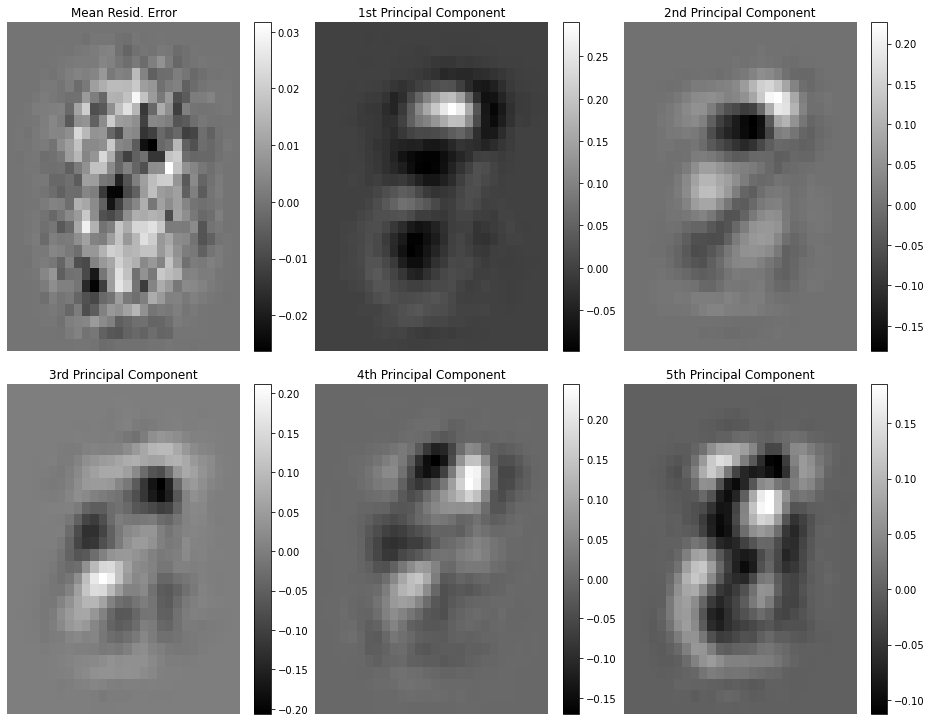

In [60]:
# decode for each square in the grid
im1 = mean.reshape(digit_size, digit_size)
im2 = vx[0:784,0].reshape(28,28)
im3 = vx[0:784,1].reshape(28,28)
im4 = vx[0:784,2].reshape(28,28)
im5 = vx[0:784,3].reshape(28,28)
im6 = vx[0:784,4].reshape(28,28)

min1 = torch.min(im1)
min2 = torch.min(im2)
min3 = torch.min(im3)
min4 = torch.min(im4)
min5 = torch.min(im5)
min6 = torch.min(im6)

max1 = torch.max(im1)
max2 = torch.max(im2)
max3 = torch.max(im3)
max4 = torch.max(im4)
max5 = torch.max(im5)
max6 = torch.max(im6)

g = []
fig1, axes1 = plt.subplots(nrows=2, ncols=3, figsize=(18., 12.))
for ax,im,mini,maxi in zip(axes1.flat, [im1,im2,im3,im4,im5,im6], [min1,min2,min3,min4,min5,min6], [max1,max2,max3,max4,max5,max6]):
    g.append(ax)
    ax.set_axis_off()
    img = ax.imshow(im, cmap='binary_r', vmin=mini, vmax=maxi)
    plt.colorbar(img, ax=ax)
    ax.set_aspect('auto')


fig1.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.06, hspace=0.1)

    
g[0].set_title('Mean Resid. Error')
g[1].set_title('1st Principal Component')
g[2].set_title('2nd Principal Component')
g[3].set_title('3rd Principal Component')
g[4].set_title('4th Principal Component')
g[5].set_title('5th Principal Component')

plt.show()


## 2. Variational autoencoder model
### **Datasets and Dataloaders**

In [62]:
## YOUR CODE HERE ##
BATCH_SIZE = 128

# Download or load downloaded MNIST dataset
# shuffle data at every epoch
trainset = torchvision.datasets.MNIST(root='./data_mnist', train=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Same for test data
testset = torchvision.datasets.MNIST(root='./data_mnist', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

### Define Encoder and Decoders
Create the encoder and decoder for our variational autoencoder (VAE).

VAEs work around a latent space who's dimension can be chosen . This is a parameter for the Encoder and Decoder classes that will be populated.

In [63]:
"""
Here, we define the variational autoencoder model.
"""
CUDA = False
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 10
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

H1 = 128
H2 = 64
ZDIMS = 10

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
    
        ## YOUR CODE HERE ##
        # ENCODER
        # 28 x 28 pixels = 784 input pixels, 400 outputs
        self.fc1 = nn.Linear(784, H1)
        # rectified linear unit layer from 400 to 400
        
        self.fc2 = nn.Linear(H1, H2)
        # rectified linear unit layer from 512 to 128
        # max(0, x)
        self.relu = nn.ReLU()
        
        self.fc31 = nn.Linear(H2, ZDIMS)  # mu layer
        self.fc32 = nn.Linear(H2, ZDIMS)  # logvariance layer
        # this last layer bottlenecks through ZDIMS connections
  
    def forward(self, x):
        ## YOUR CODE HERE ##
        h1 = self.relu(self.fc2(self.relu(self.fc1(x.view(-1, 784)))))  # type: Variable
        return self.fc31(h1), self.fc32(h1)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        ## YOUR CODE HERE ##
        # DECODER
        # from bottleneck to hidden 128
        self.fc4= nn.Linear(ZDIMS, H2)
        # max(0, x)
        self.relu = nn.ReLU()
        # from hidden 128 to hidden 512
        self.fc5= nn.Linear(H2, H1)
        # from hidden hidden 512 to 784 outputs
        self.fc6= nn.Linear(H1, 784)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        ## YOUR CODE HERE ##
        h3 = self.relu(self.fc5(self.relu(self.fc4(x))))
        return self.sigmoid(self.fc6(h3)) 

### Training and loss functions
The encoder outputs the mean (mu) and the log of the variance (logvar). This implies that the latent vector of the input image follows a gaussian distribution with mean (mu) and standard deviation (e^[0.5*logvar]). To decode this information, the decoder needs a sample from this distribution.

In [64]:
def sample(mu, logvar):
    # multiply log variance with 0.5, then in-place exponent
    # yielding the standard deviation
    std = logvar.mul(0.5).exp_()  # type: Variable
    # - std.data is the [128,ZDIMS] tensor that is wrapped by std
    # - so eps is [128,ZDIMS] with all elements drawn from a mean 0
    #   and stddev 1 normal distribution that is 128 samples
    #   of random ZDIMS-float vectors
    eps = Variable(std.data.new(std.size()).normal_())
    # - sample from a normal distribution with standard
    #   deviation = std and mean = mu by multiplying mean 0
    #   stddev 1 sample with desired std and mu, see
    #   https://stats.stackexchange.com/a/16338
    # - so we have 128 sets (the batch) of random ZDIMS-float
    #   vectors sampled from normal distribution with learned
    #   std and mu for the current input
    return eps.mul(logvar).add_(mu)

In [65]:
def vae_loss(x, x_hat, mu, logvar):
    # MSE LOSS + KL DIVERGENCE 
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(x_hat, x.view(-1, 784))
    #MSE = F.mse_loss(x_hat, x)

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

### Defining The Loss Function and The Optimizer

In [66]:
from torch import optim

encoder = Encoder(10)
decoder = Decoder(10)
params = list(encoder.parameters())+list(decoder.parameters())
#optimizer = optim.Adam(params, lr=1e-3)
optimizer = optim.Adam(params,lr=0.003)
#optimizer = optim.SGD(params, lr=0.010, momentum=0.9)

### Training the Model

In [67]:
def train(encoder, decoder, train_loader, optimizer, num_epochs = 10):
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = Variable(data)

            # zero the parameter gradients
            optimizer.zero_grad()

            # push whole batch of data through VAE.forward() to get recon_loss
            mu, logvar = encoder(data)
            z = sample(mu, logvar)
            recon_batch = decoder(z)
            
            # calculate scalar loss
            loss = vae_loss(data, recon_batch, mu, logvar)
            
            # forward + backward + optimize
            loss.backward()
            
            running_loss += loss.item()
            optimizer.step()
            
            # print statistics
            if batch_idx % LOG_INTERVAL == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader),
                        loss.data.item() / len(data)))
                
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, running_loss / len(train_loader.dataset)))

In [79]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 10)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.005431
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.002820
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.002092
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.002060
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.002015
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.001994
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.002004
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.001905
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.001912
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.001874
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.001951
Train Epoch: 0 [14080/60000 (23%)]	Loss: 0.001842
Train Epoch: 0 [15360/60000 (26%)]	Loss: 0.001824
Train Epoch: 0 [16640/60000 (28%)]	Loss: 0.001895
Train Epoch: 0 [17920/60000 (30%)]	Loss: 0.001725
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.001756
Train Epoch: 0 [20480/60000 (34%)]	Loss: 0.001647
Train Epoch: 0 [21760/60000 (36%)]	Loss: 0.001667
Train Epoch: 0 [23040/60000 (38%)]	Loss: 0.001625
Train Epoch: 0 [24320/60000 (41%)]	Loss: 0.001618
Train Epoch: 0 [

### Save the model

In [80]:
PATH = './mnist_vae1.pth'
torch.save(encoder.state_dict(), PATH)
PATH = './mnist_vae2.pth'
torch.save(decoder.state_dict(), PATH)

### Load the model
Only needed if the data has been reset

In [68]:
PATH = './mnist_vae1.pth'
encoder=Encoder(10)
encoder.load_state_dict(torch.load(PATH))
PATH = './mnist_vae2.pth'
decoder=Decoder(10)
decoder.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Interpolation
We will look at how well the codes produced by the VAE can be interpolated. *For this section we will use the MNIST test set. *

To create an interpolation between two images A and B, we encode both these images and generate a sample code for each of them. We consider 7 equally spaced points in between these two sample codes giving us a total of 9 points including the samples. We then decode these images to get interpolated images in between A and B.

In [69]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline
import numpy as np

def create_interpolates(A, B, encoder, decoder):
    with torch.no_grad():
        #Get the hidden values of the images
        a_z, a_logvar = encoder(A)
        b_z, b_logvar = encoder(B)
    
        #Create a list of interpolated tensors [0] is original image and [8] is original image
        #[1:7] are interpolates between [0] and [8]
        tensor_list = []
        tensor_list.append(a_z)
        for i in range(1,8):
            tensor_list.append(torch.lerp(a_z, b_z, i/8))
        tensor_list.append(b_z)
        
        #Return the decoded values of the interpolated images
        output = decoder(torch.stack(tensor_list))
    
    return output


### Visualizing the VAE output
For 10 pairs of MNIST test images of the same digit (1 pair for "0", 1 pair for "1", etc.), selected at random, we compute the code for each image of the pair. We then compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. We then show a visualization of these interpolates.

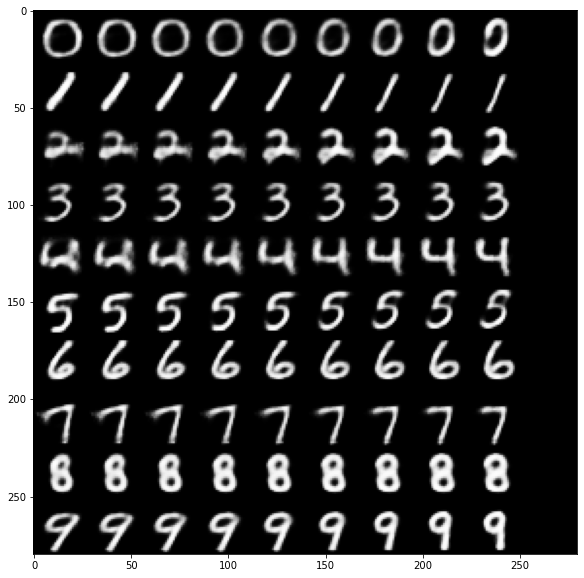

In [86]:
similar_pairs = {}
n=10
for _, (x, y) in enumerate(test_loader):
    for i in range(len(y)):
        if y[i].item() not in similar_pairs:
            similar_pairs[y[i].item()] = []
        if len(similar_pairs[y[i].item()])<2:
            similar_pairs[y[i].item()].append(x[i])
  
    done = True
    for i in range(10):
        if i not in similar_pairs or len(similar_pairs[i])<2:
            done = False
  
        if done:
            break

# similar_pairs[i] contains two images indexed at 0 and 1 that have images of the digit i

interpolates = []
for i in range(10):
    images = create_interpolates(similar_pairs[i][0], similar_pairs[i][1], encoder, decoder)
    interpolates.append(images)
    
import matplotlib.pyplot as plt

# Display a 2D manifold of the digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = np.linspace(0.05, 0.95, 10)
grid_y = np.linspace(0.05, 0.95, 9)

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        x_decoded = interpolates[i][j]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()  


For 10 pairs of MNIST test images of different digits, selected at random, we compute the code for each image of the pair. We then compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. We then show a visualization of these interpolates.

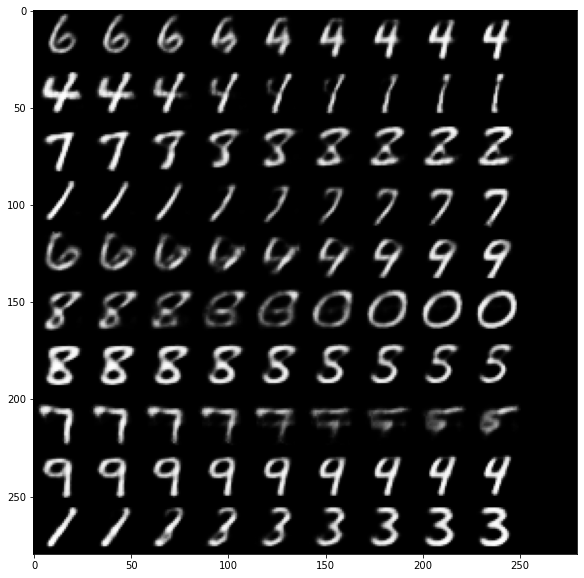

In [85]:
random_pairs = {}
n=10

for _, (x, y) in enumerate(test_loader):
    # Make sure the batch size is greater than 20
    for i in range(10):
        for j in range(i, len(x//2)):
            random_pairs[i] = []
            random_pairs[i].append(x[2*i])
            if (y[2*i] != y[2*j+1]):
                random_pairs[i].append(x[2*j+1])
                break
    
    break
    
    
# random_pairs[i] contains two images indexed at 0 and 1 that are chosen at random

interpolates = []
for i in range(10):
    images = create_interpolates(random_pairs[i][0], random_pairs[i][1], encoder, decoder)
    interpolates.append(images)

# Display a 2D manifold of the digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = np.linspace(0.05, 0.95, 10)
grid_y = np.linspace(0.05, 0.95, 9)

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        x_decoded = interpolates[i][j]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()  